# Descriptive statistics of the EWI predictors

We selected a handful set of variables among the routinely collected data to predict the fosa with outlying early warning indicators (EWI).
In this notebook, we look at the missingness patterns and distribution of these predictors.

In [95]:
import bluesquare_data_pipelines.access as blsq
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

Loading the data

In [96]:
hivdr_de = pd.read_csv("../data/processed/hivdr_de_mapping.csv", sep=';')
iap_covariates = pd.read_csv("../data/processed/iap_covariates.csv")
iap_matched = pd.read_csv("../data/processed/iap_fosa_matched.csv")
iap_matched = iap_matched.dropna()

/anaconda3/envs/bsqvenv/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [97]:
labelled_covariates = iap_covariates.merge(hivdr_de)
full_data = labelled_covariates.merge(iap_matched, left_on = "uidorgunit", right_on = "fosa_id")
full_data = full_data[['monthly', 'quarterly', 'dataelementname', 'catcomboname','population', 
                       'action', 'sub_population', 'province', 'fosa','value']]

In [98]:
def make_sum(data):
    if data.value.iloc[0] in ["true", "false"]:
        out = pd.DataFrame.from_dict({"value":[data.value.iloc[0]]})
    else :
        data.value = data.value.astype(float)
        out = pd.DataFrame.from_dict({"value":[data.value.sum()]})
    return out

full_data = full_data.groupby(["province","fosa","monthly","quarterly", "population","action","sub_population","dataelementname"]).apply(make_sum)

In [99]:
full_data = full_data.reset_index().drop("level_8", 1)
full_data["standard_de"] = full_data["population"] + "_" + full_data["action"]  + "_" + full_data["sub_population"]

In [100]:
useful_variables = full_data[~(full_data.population == "vih_positive") &  
                             ~(full_data.action.str.contains("tb|cv|_ist|dead|cotrim|nut|treatment_supplement|no_treatment_response|counciled_tested")) &
                             ~(full_data.sub_population.str.contains("soutien"))]

In [101]:
#len(useful_variables)

In [102]:
#len(useful_variables.fosa.unique().tolist())

In [103]:
treat_scheme = ["azt_3tc_lpv_r","tdf_ftc_nvp","abc_3tc_nvp","abc_3tc_efv","azt_3tc_efv","tdf_3tc_efv",
                "tdf_3tc_nvp","tdf_3tc_lpv_r","tdf_ftc_efv","azt_3tc_nvp","abc_3tc_lpv_r","tdf_ftc_lpv_r"]

treatments = useful_variables[useful_variables.sub_population.isin(treat_scheme)]
treatments_fu = treatments.groupby(["province","fosa","monthly","sub_population"]).value.sum().reset_index()
treatments_fu["line"] = 'first_line'
treatments_fu.loc[treatments_fu.sub_population.str.contains("lpv"),"line"] = "second_line"
line_fu = treatments_fu.groupby(["province","fosa","line"]).value.mean().reset_index()
line_fu = line_fu.set_index(["province","fosa"]).pivot(columns = "line")["value"].reset_index()

In [104]:
#len(line_fu)

In [105]:
pdv_data = useful_variables[(useful_variables.action == "pdv")]
pdv_data.value = pd.to_numeric(pdv_data.value)
pdv_data = pdv_data.groupby(["province","fosa"]).value.mean().reset_index()
pdv_data.columns = ["province", "fosa", "n_pdv"]

/anaconda3/envs/bsqvenv/lib/python3.7/site-packages/pandas/core/generic.py:5096: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[name] = value


In [106]:
#print(pdv_data) # "losing" 13 fosas

In [107]:
pvvih_data = useful_variables[(useful_variables.population == "pvvih") & (useful_variables.action == "enrolled_hiv_services")]
pvvih_data.value = pd.to_numeric(pvvih_data.value)
pvvih_data = pvvih_data.groupby(["province","fosa"]).value.mean().reset_index()
pvvih_data.columns = ["province", "fosa", "n_pvvih"]

In [108]:
#len(pvvih_data) # losing 10 fosas

In [109]:
stock_out_data = useful_variables[useful_variables.action == "rupture_stock_mois"]
def stock_out_prob(data):    
    return sum(data == "true") / len(data)


stock_out_data = stock_out_data.groupby(["province","fosa"]).value.apply(stock_out_prob).reset_index()
stock_out_data.columns = ["province", "fosa", "stockout_perc"]

In [110]:
#len(stock_out_data)

In [111]:
cmm_data = useful_variables[useful_variables.action == "cmm_mois"]

cmm_data = cmm_data.groupby(["province","fosa","monthly"]).value.sum().reset_index().groupby(["province","fosa"]).value.sum().reset_index()
cmm_data.columns = ["province", "fosa", "cmm"]

In [112]:
#len(cmm_data)

In [113]:
covariables = cmm_data.merge(stock_out_data).merge(line_fu).merge(pdv_data)#.merge(pvvih_data)#.merge(pdv_data)#.merge(line_fu
print(len(covariables))

63


In [114]:
#covariables.head(n=20)

In [115]:
covariables_tot = cmm_data.merge(stock_out_data, how = 'outer').merge(line_fu, how = 'outer').merge(pdv_data, how = 'outer').merge(pvvih_data, how = 'outer').merge(pdv_data, how = 'outer').merge(line_fu, how = 'outer')
#covariables_tot.head(n=20)
covariables_tot['adminid'] = covariables_tot.province.astype(str).str[-4:]
covariables_tot = covariables_tot.reset_index()

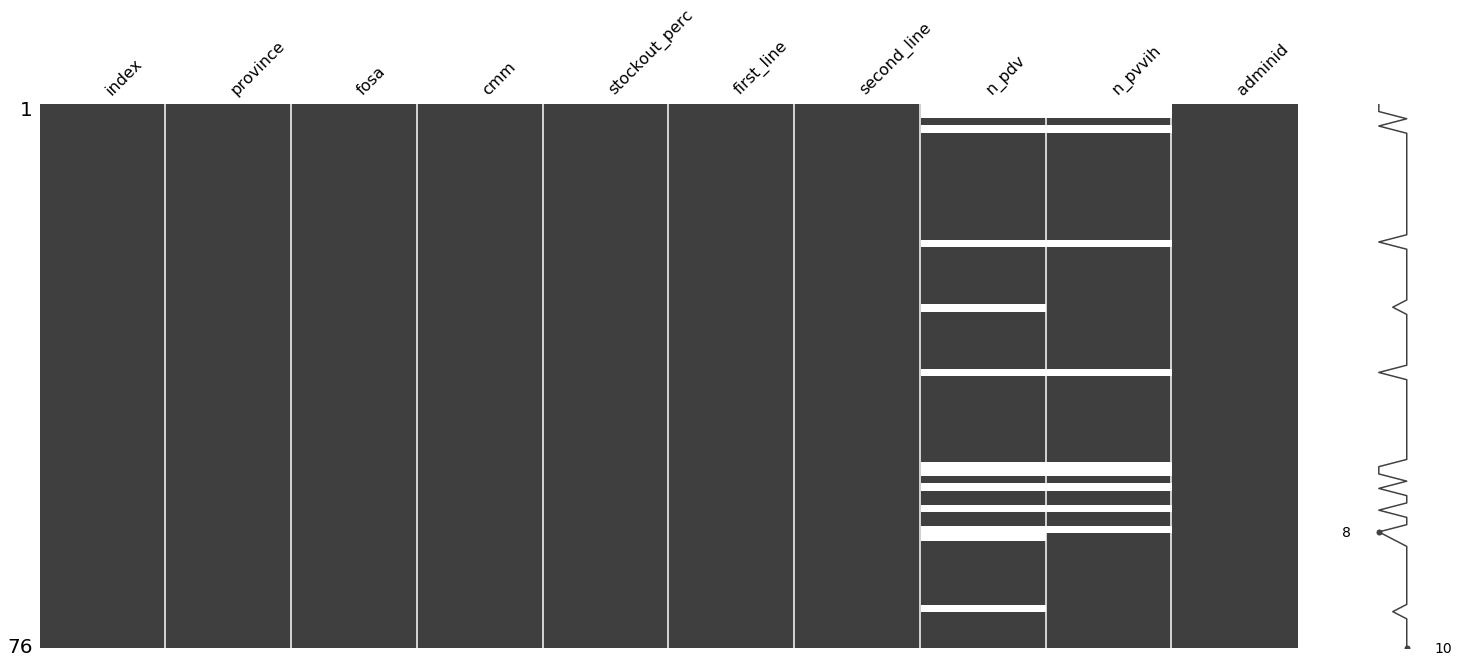

In [123]:
import missingno as msno
%matplotlib inline
msno.matrix(covariables_tot)

In [117]:
import geopandas as gpd
shapefile = gpd.read_file("../data/ZAI.shp")
shapefile['adminid'] = shapefile.loc[:,'ADM1'].str.lower().astype(str).str[-4:]
shapefile = shapefile.reset_index()

In [118]:
shape_data = shapefile.merge(covariables_tot, on = 'adminid', how = "outer")
shape_data['NumberMissing']=shape_data.isnull().sum(axis=1)

### Missingness spatial pattern

We look at the spatial distribution of missingness; the lighter the more information we have at disposal in the data.

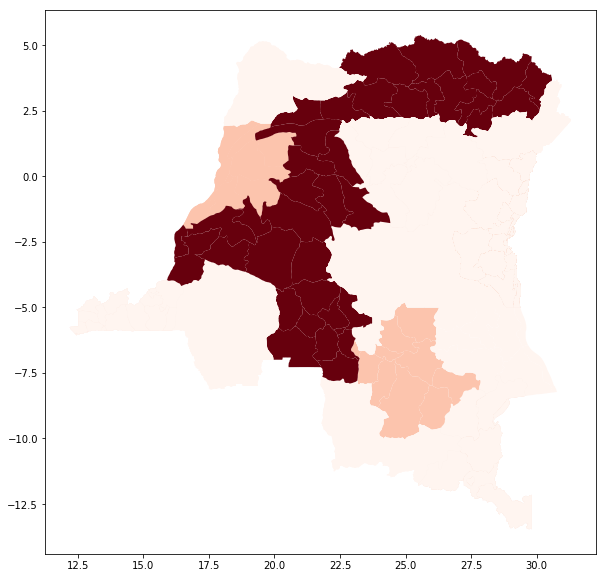

In [119]:
import descartes
shape_data.plot(figsize=(10,10), column = 'NumberMissing', cmap = 'Reds')

### Correlation between EWI predictors

We use a heatmap to see if the predictors are correlated. The *first* and *second* line are intrinsically related; it is therefore reassuring to observe that they are correlated. Otherwise, the other variables are scarcely correlated.

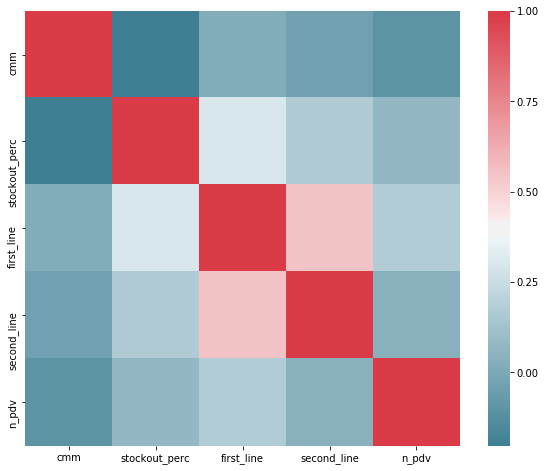

In [120]:
f, ax = plt.subplots(figsize=(10, 8))
corr = covariables.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)

### Distribution of the EWI predictors

Finally, we look at the distribution of the EWI predictors.

Text(0.5, 0.98, 'Distribution of the predictors for EWIs')

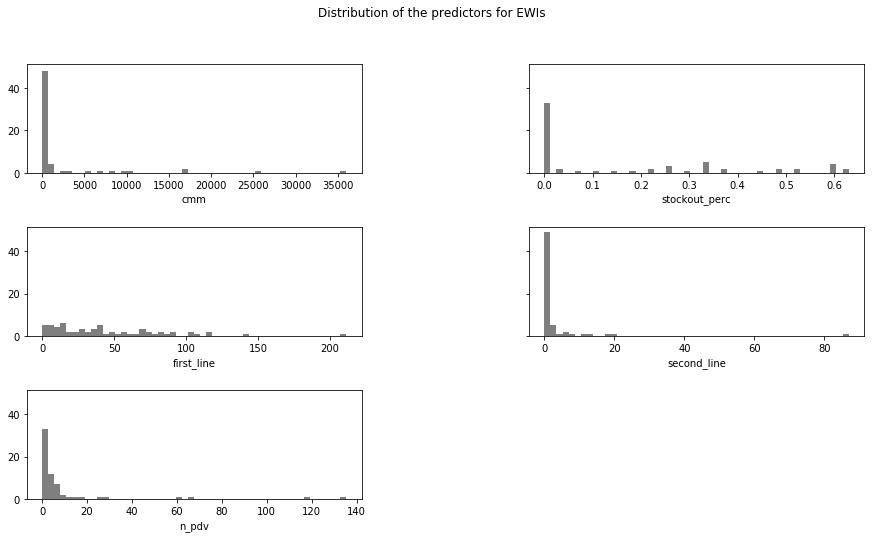

In [121]:
fig,axes = plt.subplots(3,2,sharex=False,sharey=True, figsize=(15, 8))
axes[-1, -1].axis('off')

axes[0,0].hist(covariables[covariables.columns[2]],bins=50,color='k',alpha=0.5)
axes[0,0].set_xlabel(covariables.columns[2])

axes[0,1].hist(covariables[covariables.columns[3]],bins=50,color='k',alpha=0.5)
axes[0,1].set_xlabel(covariables.columns[3])

axes[1,0].hist(covariables[covariables.columns[4]],bins=50,color='k',alpha=0.5)
axes[1,0].set_xlabel(covariables.columns[4])

axes[1,1].hist(covariables[covariables.columns[5]],bins=50,color='k',alpha=0.5)
axes[1,1].set_xlabel(covariables.columns[5])

axes[2,0].hist(covariables[covariables.columns[6]],bins=50,color='k',alpha=0.5)
axes[2,0].set_xlabel(covariables.columns[6])

plt.subplots_adjust(wspace=.5,hspace=.5)
plt.suptitle('Distribution of the predictors for EWIs')